In [135]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt
from progressbar import log_progress

# Load datasets

### Breast Cancer

In [136]:
dataset = load_breast_cancer()

In [137]:
df_x_bc = pd.DataFrame(dataset['data'], columns = dataset['feature_names']) #samples (539 vectors)

In [138]:
df_y_bc = dataset['target'] # labels (539 labels 1 == maniglent, 0 == benign)

### Phoneme

In [155]:
df_phoneme = pd.read_csv("./datasets/phoneme.dat/data", sep="\s+", header=None)

In [156]:
df_x_phoneme = df_phoneme.iloc[:,0:5]

In [157]:
df_y_phoneme = np.ravel(df_phoneme.iloc[:,5:6])

## choose Dataset

In [158]:
dataset = "phoneme"

In [159]:
if dataset == "phoneme":
    df_x = df_x_phoneme
    df_y = df_y_phoneme
if dataset == "breastcancer":
    df_x = df_x_bc
    df_y = df_y_bc

# Initialize Parameters

In [160]:
n_estimators = 250 # boosting iterations
max_depth = 8
procent_noise = 5
n_flips = round(len(df_y) * (procent_noise/100)) # number of label filps for 2% noise
number_of_rounds = 10 # 100 for real experiment

ada_err_test = np.zeros((number_of_rounds,n_estimators))
ada_err_train = np.zeros((number_of_rounds,n_estimators))

rf_err_test = np.zeros((number_of_rounds,n_estimators))
rf_err_train = np.zeros((number_of_rounds,n_estimators))

# Choose Datset and Add noise

In [161]:
a = np.arange(len(df_y))
np.random.shuffle(a)
for idx in a[:n_flips]: # apply noise
    df_y[idx] = abs(df_y[idx]-1)

# Run Classifiers

## Adaboost

In [162]:
for r in log_progress(range(number_of_rounds), every=1): # number of train/test split rounds. 
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
        n_estimators=n_estimators,
        algorithm="SAMME.R") # init AdaBoost
    
    X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, test_size=0.3) # split to train/test set (0.7, 0.3)
    
    ada.fit(X_train, Y_train) # train the classifier
    
    for i, y_pred in enumerate(ada.staged_predict(X_test)):
        ada_err_test[r][i] = zero_one_loss(y_pred, Y_test) # validate boosting rounds with test set

    
    for i, y_pred in enumerate(ada.staged_predict(X_train)):
        ada_err_train[r][i] = zero_one_loss(y_pred, Y_train) # validate boosting rounds with train set

VBox(children=(HTML(value=''), IntProgress(value=0, max=10)))

## Randomforest

In [163]:
for r in log_progress(range(number_of_rounds), every=1): # number of train/test split rounds. 
    X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, test_size=0.3) # split to train/test set (0.7, 0.3)
    for i in range(1, n_estimators+1):
        rf = RandomForestClassifier(max_depth=None, n_estimators=i) # init RandomForests

        rf.fit(X_train, Y_train) # train the classifier

        rf_err_test[r][i-1] = zero_one_loss(rf.predict(X_test), Y_test)
        rf_err_train[r][i-1] = zero_one_loss(rf.predict(X_train), Y_train)

VBox(children=(HTML(value=''), IntProgress(value=0, max=10)))


# Plot validation

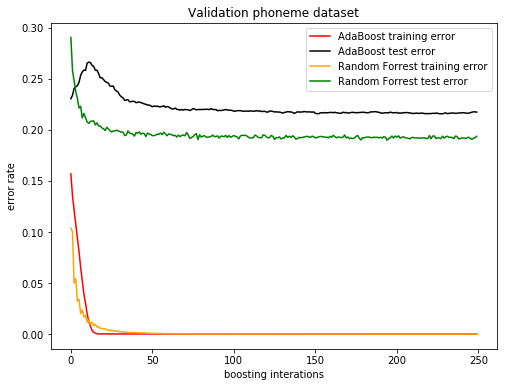

In [164]:
fig = plt.figure(figsize=(8, 6))
plt.plot(ada_err_train.mean(axis=0), label="AdaBoost training error", color="red")
plt.plot(ada_err_test.mean(axis=0), label="AdaBoost test error", color="black")
plt.plot(rf_err_train.mean(axis=0), label="Random Forrest training error", color="orange")
plt.plot(rf_err_test.mean(axis=0), label="Random Forrest test error", color="green")
plt.ylabel("error rate")
plt.xlabel("boosting interations")
plt.title(f"Validation {dataset} dataset")
plt.legend()#loc='lower right', bbox_to_anchor=(1, 0.2))
plt.show()
#fig.savefig(f"results/{dataset}_{procent_noise}percent_noise.png", dpi=fig.dpi)

In [165]:
print(f"test error AdaBoost @ {procent_noise}% noise: {ada_err_test.mean(axis=0)[-1]}")
print(f"test error random forests @ {procent_noise}% noise: {rf_err_test.mean(axis=0)[-1]}")

test error AdaBoost @ 10% noise: 0.217324290998767
test error random forests @ 10% noise: 0.19364981504315662


In [170]:
print(f"average rf tree depth: {np.mean([estimator.tree_.max_depth for estimator in rf.estimators_])}")

average rf tree depth: 25.092
